In [29]:
# import modules and libraries
import cv2
import numpy as np
import skimage
import skimage.color as skcolor
import skimage.io as sio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import skimage.util as skt
from skimage.feature import blob_dog, blob_log, blob_doh

In [36]:
# Define rgb2grayscale function.
def gray_scaler(path):
    img = sio.imread(path)  
    # Read image file with skimage.io.
    if len(img) > 1:
    # If the image file is multiple page, treat the first column as page.
        graylist = []
        # Empty list to store output.
        # Iterate through the length of the file.
        for i in range(len(img)):
            # Append the grayscale result into empty list.
            graylist.append(skimage.color.rgb2gray(img[i,:]))
        # Turn the output into numpy array.
        gray = np.asarray(graylist)
    # If the image file is single page, directly use the skimage built-in rgb2gray function.  
    else:
        gray = skimage.color.rgb2gray(img)

    return gray

In [44]:
# Define normalizing function.
def img_normalizer(img):
    # Set empty lists to store output.
    maxlist = []
    minlist = []
    # Iterate through the file length to find the maximum and minimum within the file.
    for i in range(len(gray)):
        gmax = np.amax(gray[i,:])
        gmin = np.amin(gray[i,:])
        maxlist.append(gmax)
        minlist.append(gmin)
    graymax = np.asarray(maxlist).max()
    graymin = np.asarray(minlist).min()
    # Set up zero function to create a zero array to store output and maintain the shape.
    norm_gray = np.zeros(gray.shape)
    # Iterate through the file length to normalize the pixel value from 0 to 255.
    for i in range(len(gray)):
        norm_gray[i, :] = ((gray[i, :] - graymin) / (graymax - graymin)) * 255
    # Find and output the mean value and standard deviation of normalized images as a parameter in ROI locator function.
    norm_gray_mean = []
    norm_gray_std = []
    for i in range(len(norm_gray)):
        norm_gray_mean.append(np.asarray(norm_gray[i]).mean())
        norm_gray_std.append(np.asarray(norm_gray[i]).std())
    # Output the uint16 data type for later usage.
    ngray = norm_gray.astype('uint16')
    return norm_gray, norm_gray_mean, norm_gray_std, ngray

In [45]:
# define difference of Gaussian function
def diff_of_gauss(img):
    # Run normalizer function to get the output.
    norm_gray, ngraymean, ngraystd, ngray = img_normalizer(img)
    # Set empty list to store output.
    roi = []
    for i in range(len(norm_gray)):
        # Use blob_dog function from skimage.feature to capture ROI based on local maximum brightness.
        roi.append(blob_dog(norm_gray[i, :], max_sigma=30, threshold = ngraymean[i] + 3 * ngraystd[i], overlap = 0.1))
    return roi

In [183]:
# define wrapping function.
def ROI_locator(path):
    # Run gray_scaler function to obtain grayscale image as numpy array.
    gray = gray_scaler(path)
    # Run diff_of_gauss function to obtain list of ROI.
    roi = diff_of_gauss(gray)
    roi_count = ROI_counting(roi, gray)
    return roi, roi_count

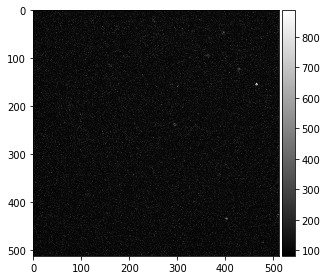

In [40]:
# This cell serves for checking if the ROI_locator works right.
path3 = r'C:\Users\robin\OneDrive\Documents\DIRECT\final_project\video3.tif'
gray = gray_scaler(path3)
sio.imshow(gray[1364,:], cmap=plt.cm.gray)

In [46]:
# This cell serves for checking if the ROI_locator works right.
path = r'C:\Users\robin\OneDrive\Documents\DIRECT\final_project\video3.tif'
roi = ROI_locator(path)
roi[1364]

array([[154.  , 465.  ,   2.56]])

In [180]:
roi_count_d = 0
for j in range(len(roi[888])):
    for k in range(len(roi[889])):
        if [roi[888][j][0], roi[888][j][1]] == [roi[889][k][0], roi[889][k][1]]:
            roi_count_d += 1
roi_count_d

2

In [176]:
roi[889]

array([[434.  , 402.  ,   2.56],
       [154.  , 465.  ,   2.56]])

In [177]:
roi[888]

array([[434.  , 402.  ,   2.56],
       [154.  , 465.  ,   2.56]])

In [181]:
# Define ROI counting function.
def ROI_counting(roi, img):
    # Initial count for first frame.
    roi_count = len(roi[0])
    index_list = []
    for i in range(1, len(img)):
        # Count the ROIs that appear frame by frame.
        # If the ROI amount increases over the frame, calculate how many ROI appears.
        if len(roi[i - 1]) < len(roi[i]):
            roi_count += len(roi[i]) - len(roi[i - 1])
        # If the ROI amounts are same between two frames, check if there's different ROI.
        # Store the index number for the frames which have the same amount of ROI as previous frame.
        elif len(roi[i - 1]) == len(roi[i]):
            index_list.append(i)
    # Set up a loop for finding if there is different ROI between two frames that have same amount of ROI.
    for i in index_list:
        # A count that is used only in the loop, counting the amount of identical ROI between two frames.
        roi_count_d = 0
        for j in range(len(roi[i - 1])):
            for k in range(len(roi[i])):
                # Find how many identical ROI there are between two frames.
                if [roi[i - 1][j][0], roi[i - 1][j][1]] == [roi[i][k][0], roi[i][k][1]]:
                    roi_count_d += 1
        # Adding the amount of different ROI within two frames that have same amount of ROI
        roi_count += len(roi[i]) - roi_count_d
    return roi_count
        

In [182]:
roi_count = ROI_counting(roi, gray)
roi_count

463

The ROI_locator may take several minutes to run, depending on the configuration of your computer. I got a decent computer (i7-8750H @2.20 GHz, RTX2060, 16GB RAM) but still takes around 5 minutes.